In [2]:
import numpy as np
import pandas as pd
import scipy

In [1]:
! ls

gaits.csv            log_trajectories.csv walk_analyser.ipynb


In [6]:
df = pd.read_csv('./log_trajectories.csv')

In [8]:
df.head(5)

,episode,reward,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,...,obs_29,obs_30,obs_31,obs_32,obs_33,obs_34,obs_35,obs_36,obs_37,obs_38
0,0,-0.815212,-0.326533,0.371534,-0.574627,-1.974846,-0.713321,-1.089413,-1.016436,3.018981,...,-0.000660,-1.422328,-0.009183,-0.237934,-0.511881,-0.521056,-0.299684,-0.433531,-0.348542,0.000
1,1,-0.612313,-0.325654,-0.211907,-0.259909,-1.573071,0.275161,-0.840190,0.068656,1.984353,...,-0.090354,-1.375577,0.484458,-0.237934,-0.511881,-0.521056,-0.299684,-0.433531,-0.348542,0.001
2,2,-0.664656,-0.444067,-0.197823,-0.603266,-1.447586,0.108975,-1.130868,0.367934,1.454077,...,-0.149349,-1.272934,0.780476,-0.237934,-0.511881,-0.521056,-0.299684,-0.433531,-0.348542,0.002
3,3,-0.498860,-0.836055,-0.502772,-0.363469,-0.278782,0.432985,-0.717119,0.441241,0.747007,...,-0.223284,-1.137149,0.949820,-0.237934,-0.511881,-0.521056,-0.299684,-0.433531,-0.348542,0.003
4,4,0.119132,-0.081220,0.065608,-0.549403,-0.307242,0.425951,-0.148720,0.346286,-0.569584,...,-0.248988,-0.965494,1.226957,-0.237934,-0.511881,-0.521056,-0.299684,-0.433531,-0.348542,0.004


In [11]:
walk_data = df.loc[:, "obs_32":"obs_37"]
walk_data.head(5)

,obs_32,obs_33,obs_34,obs_35,obs_36,obs_37
0,-0.237934,-0.511881,-0.521056,-0.299684,-0.433531,-0.348542
1,-0.237934,-0.511881,-0.521056,-0.299684,-0.433531,-0.348542
2,-0.237934,-0.511881,-0.521056,-0.299684,-0.433531,-0.348542
3,-0.237934,-0.511881,-0.521056,-0.299684,-0.433531,-0.348542
4,-0.237934,-0.511881,-0.521056,-0.299684,-0.433531,-0.348542


In [19]:
walk_data = walk_data.applymap(lambda x: 0 if x < 0 else 1)
walk_data.head(5)

,obs_32,obs_33,obs_34,obs_35,obs_36,obs_37
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [14]:
0 if 5 < 0 else 1

1

In [100]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline

def draw_feet_graph(feet_data, feet_names, feet_colors, delta=0.2, max_length=500):
    foot_count = len(feet_names)
    yspan = foot_count
    yplaces = [.5 + i for i in range(yspan)]
    ylabels = feet_names

    fig = plt.figure(figsize=(10, 3), dpi=100)
    ax = fig.add_subplot(111)
    ax.set_yticks(yplaces)
    ax.set_yticklabels(ylabels)
    ax.set_ylim((0, yspan))
    ax.set_xlim((0, max_length))
    #         ax.set_xlabel('Nogi')

    xmin, xmax = ax.get_xlim()
#     ax.hlines(range(1, yspan), xmin, xmax)
    time_step = 0
    vlines = []
    main_foot_curr_contact = False
    main_foot_last_contact = False
    
    for contacts in feet_data:
        if time_step > max_length:
            break
        for i in range(foot_count):
            if contacts[i] < 0.5:
                continue
            start, end = time_step, time_step + 1
            pos = yplaces[i]
            ax.add_patch(patches.Rectangle((start, pos - delta / 2.0), end - start, delta, color=feet_colors[i]))
            
        main_foot_curr_contact = True if contacts[0] > 0.5 else False
        if main_foot_curr_contact is True and main_foot_last_contact is False:
            vlines.append(time_step)
        main_foot_last_contact = main_foot_curr_contact
        time_step += 1
        
    for x in vlines:
        ax.axvline(x,0,1, lw=0.5, color=feet_colors[0])
    fig.canvas.draw()

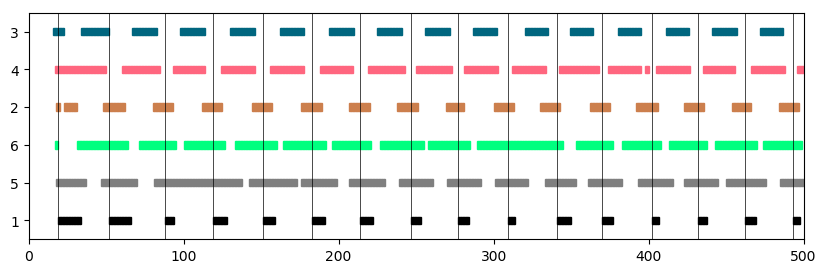

In [77]:
foot_list = ['1', '5', '6', '2', '4', '3']
foot_colors = ['#000000', '#7f7f7f', '#00ff7f', '#cc7f4d', '#ff667f', '#00667f']
draw_feet_graph(walk_data.values, foot_list, foot_colors)

In [40]:
# сделаем нормальный порядок
permutation = [0, 4, 5, 1, 3, 2]
idx = np.argsort(permutation)
wd = walk_data.values
wd = wd[:,idx]

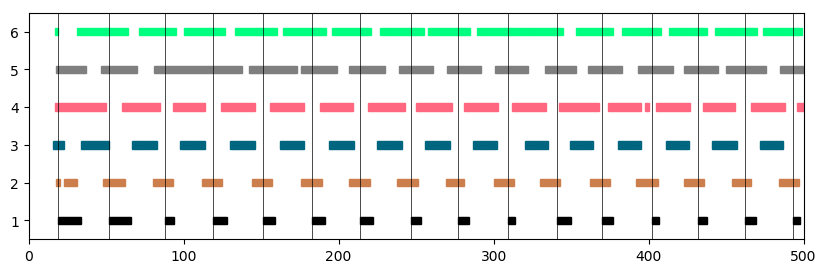

In [73]:
new_foot_colors = ['#000000', '#cc7f4d', '#00667f', '#ff667f', '#7f7f7f', '#00ff7f']
new_foot_list = ['1', '2', '3', '4', '5', '6']
draw_feet_graph(wd,new_foot_list, new_foot_colors)

In [74]:
gdf = pd.read_csv('./gaits.csv')

In [76]:
gdf.head(5)

,gait_name,beta,phi2,phi3,phi4,phi5,phi6
0,galop,0.66,0.00,0.66,0.66,0.33,0.33
1,triple,0.50,0.50,0.50,0.00,0.00,0.50
2,sequence,0.83,0.16,0.33,0.66,0.83,0.50


In [80]:
gaits = gdf.set_index('gait_name').T.to_dict()
gaits

{'galop': {'beta': 0.66,
  'phi2': 0.0,
  'phi3': 0.66,
  'phi4': 0.66,
  'phi5': 0.33,
  'phi6': 0.33},
 'sequence': {'beta': 0.83,
  'phi2': 0.16,
  'phi3': 0.33,
  'phi4': 0.66,
  'phi5': 0.83,
  'phi6': 0.5},
 'triple': {'beta': 0.5,
  'phi2': 0.5,
  'phi3': 0.5,
  'phi4': 0.0,
  'phi5': 0.0,
  'phi6': 0.5}}

In [206]:
def draw_gait(d, T=60, cycles=5):
    # сгенерируем точки и отрисуем через draw_feet_graph
    feet_data = np.zeros((T,6))
    d["phi1"] = 0
    for i in range(6):
        start_contact = int(T * d["phi"+str(i+1)]) 
        end_contact = int(T * ((d['beta'] + d["phi"+str(i+1)]) % 1))
        if start_contact > end_contact:
#             print("revert")
            for j in range(0, end_contact, 1):
                feet_data[j,i] = 1
            for j in range(end_contact, start_contact, 1):
                feet_data[j,i] = 0
            for j in range(start_contact, T, 1):
                feet_data[j,i] = 1
        else:
            for j in range(start_contact, end_contact, 1):
                feet_data[j,i] = 1
#         print(start_contact, end_contact)
        
#     print(feet_data)
    feet_data = np.array(feet_data)
    fd = feet_data
    for i in range(cycles):
        fd = np.concatenate((fd,feet_data))
    draw_feet_graph(fd, new_foot_list, new_foot_colors)

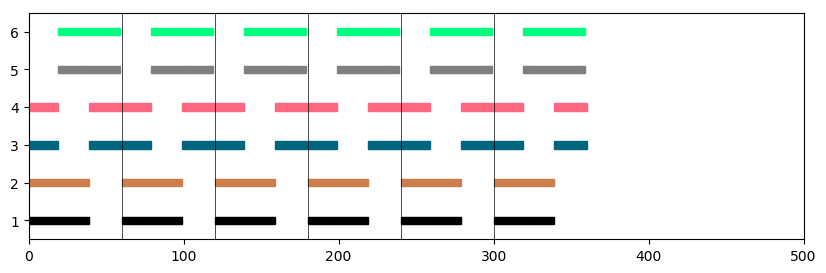

In [207]:
draw_gait(gaits["galop"])

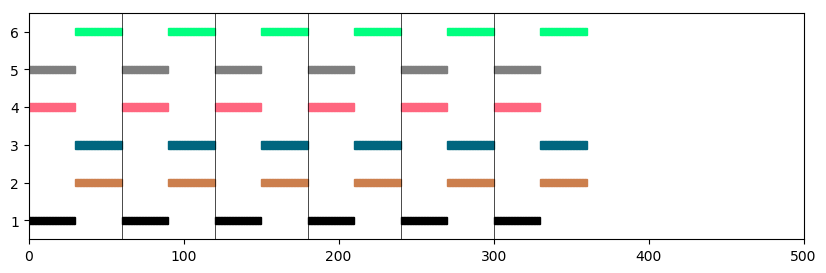

In [208]:
draw_gait(gaits["triple"])

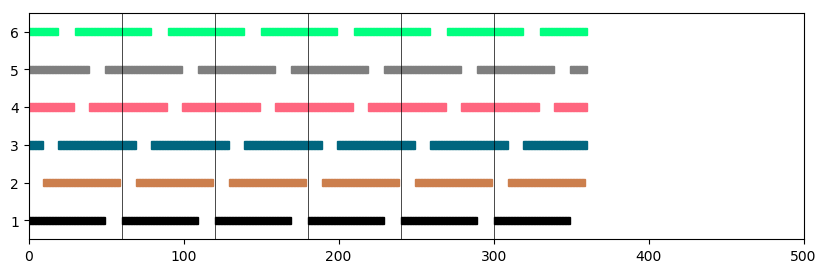

In [209]:
draw_gait(gaits["sequence"])